## Topic Modeling with Sklearn

영화 리뷰 데이터를 이용하여 topic modeling을 학습

### Topic Modeling이란?

참조: https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/06/01/LDA/

토픽모델링은 텍스트 형태로 되어 있는 다수의 문서들로부터 공통적으로 내재되어 있는 주제들을 추출하기 위한 방법론이다. <br>
토픽모델링의 기본적인 가정은, 저자들이 문서를 작성할 때 먼저 특정한 주제들을 정하고 나서 그러한 주제들로부터 문장을 구성한다는 것이다. 따라서 문서를 구성하는 단어들은 그 주제들로부터 파생되어진 것으로 볼 수 있으며, 토픽모델링은 문서와 단어들에 대해 통계적인 추론을 수행하여 본래의 주제들을 찾아내는 방법이라고 할 수 있다.  <br>
이러한 작업을 하기 위해서는 먼저 자연어로 기술되어 있는 문서들에 대해 형태소 분석을 함으로써 문장들을 개별 단어로 분리해야 한다. 
 <br>
토픽모델링의 가장 대표적인 알고리즘은 LDA(Latent Dirichlet Allocation)로 알려져 있다.  <br>
LDA는 Blei et al. (2003)에 의해 제안된 알고리즘으로, 앞서 설명한 바와 같이, 확률기법을 기반으로 하여 문서의 토픽 분포를 추론한다.  <br>
LDA에서 토픽은 주제를 의미하는 용어로 사용되며, 각 문서들이 특정한 주제에 속할 확률분포와 주제로부터 특정 단어들이 파생되어 나올 확률분포가 주어졌을 때, 이 두 확률분포를 조합하여 각 문서들에 들어가는 단어들의 확률분포를 계산해낸다.  <br>
아래 그림에서 θ는 문서들이 각 주제들에 속할 확률분포를 나타내며 디리클레분포의 매개변수인 α에 의해 결정된다.  <br>
그림에서 N은 특정 문서에 속한 단어의 집합이며, M은 전체 문서의 집합을 나타낸다. z는 문서 내의 단어들이 주제들에 속할 확률분포를 나타내며, 이는 θ에 의한 다항분포로 선택된다.  <br>
β는 각 주제가 특정 단어를 생성할 확률을 나타내는 확률분포이며, 결국 z와 β에 의해 실제 문서들의 단어분포인 w가 결정된다.  <br>
이 모형에서 w만이 실제로 문서들을 통해 주어진 분포이고 나머지는 모두 잠재변수이다.  <br>
LDA 알고리즘에서는 주어진 문서와 토픽들의 사전확률 분포인 α와 토픽 내에서 단어의 사전확률분포인 β의 파라미터 값을 활용해 반복적인 시뮬레이션을 통해 z와 θ를 추정한다. 

In [16]:
import os
os.getcwd()

'/content'

다음무비에서 추출한 영화 리뷰를 불러온다.

In [17]:
#다음무비에서 추출한 영화리뷰
import pandas as pd

movie = pd.read_csv('movie_data_new(1).csv', header = None) # header를 None으로 설정해 header가 없음을 알림

print('리뷰 수:', len(movie))
print('리뷰영화:', set(movie.loc[:,2]))

리뷰 수: 14967
리뷰영화: {'신과함께', '코코', '라라랜드', '범죄도시', '택시운전사', '인피니티 워', '곤지암'}


In [18]:
movie[:10]

,0,1,2
0,헐..다 죽었어....나중에 앤트맨 보다가도 깜놀...,10,인피니티 워
1,충격 결말,9,인피니티 워
2,응집력,8,인피니티 워
3,개연성은 무시해라 액션을 즐겨라 스타로드가 이끌어준다 각각의 영웅들을 즐겨라 그리고...,8,인피니티 워
4,내가졸라이상하네,4,인피니티 워
5,대박,10,인피니티 워
6,정말 지루할틈없이 넘잘만들었다 역시 대단하다,9,인피니티 워
7,역시 어벤져스!!,9,인피니티 워
8,마지막에 누구한테 연락한거지? 궁금,9,인피니티 워
9,다음 편이 궁굼해지네요^^,10,인피니티 워


In [19]:
text = movie.loc[:,0] # 전체행에 대해 1번째 열만 인덱싱 - 리뷰들만 가져옴

In [22]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 53.1 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
     |████████████████████████████████| 448 kB 41.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


#### 한글 처리를 위해서는 konlpy가 필요

topic modeling은 count vector를 사용하므로 sklearn의 CountVectorizer를 사용

In [23]:
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twitter_tag = Okt()

from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(tokenizer=twitter_tag.nouns, #우선은 명사만 사용
                      decode_error ='ignore', 
                      max_df=0.5, #너무 자주 나타나는 단어는 제외, 책에서는 0.15를 사용
                      #min_df = 3, #3개 미만의 문서에서 나타난 단어는 제외, 여기서는 max_features를 1000으로 제한하므로 별 필요 없음
                      max_features = 1000) #적당한 대상 단어 수를 선택
review_cv = vec.fit_transform(text)

In [24]:
review_cv.shape

(14967, 1000)

#### sklearn의 LatentDirichletAllocation을 이용하여 topic modeling 수행
다양한 argument를 적절히 이용하는 것이 중요

In [26]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수를 지정
                                max_iter=25, #max_iter는 최종 모형에서는 5,000~10,000번 시도한다고 알려져 있음
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                #topic_word_prior: beta, doc_topic_prior: alpha
                                #일반적으로 beta는 0.1로 고정하고 alpha를 50/topic의 수 근처의 값을 시도
                                #alpha와 beta는 낮은 값을 사용할수록 특정 토픽들이 두드러지도록 하는 효과가 있다고 합
                                learning_method='batch', #'batch'는 'online'에 비해 더 성능이 좋고 느림, 현재는 default
                                n_jobs= -1, #사용 processor 수, None이면 1, -1이면 모두 사용
                                random_state=0)

review_topics = lda.fit_transform(review_cv)

In [27]:
print('topic-word distribution dimension:', lda.components_.shape)
print('document-topic distribution dimenstion', review_topics.shape)

topic-word distribution dimension: (10, 1000)
document-topic distribution dimenstion (14967, 10)


#### topic을 보기 쉽게 출력하는 함수를 작성

In [28]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

In [29]:
print_top_words(lda,vec.get_feature_names(), 10)

Topic #0: 정말, 생각, 기대, 원작, 내, 안, 인생, 작품, 난, 굿
Topic #1: 더, 그, 광주, 말, 다시, 가슴, 우리, 한번, 송강호, 택시
Topic #2: 것, 좀, 장면, 때, 나, 음악, 사랑, 이야기, 번, 현실
Topic #3: 스토리, 시간, 돈, 정도, 신파, 감독, 거, 한국, 듯, 수준
Topic #4: 그냥, 편, 마블, 뭐, 이해, 공포, 역시, 노스, 느낌, 다음
Topic #5: 마동석, 최고, 볼, 함, 액션, 공포영화, 임, 완전, 걸, 중
Topic #6: 사람, 점, 수, 꼭, 부분, 이, 분, 웹툰, 역사, 조금
Topic #7: 감동, 눈물, 재미, 마지막, 보고, 내용, 가족, 처음, 끝, 추천
Topic #8: 연기, 배우, 진짜, 왜, 윤계상, 차태현, 연출, 대박, 또, 조연
Topic #9: 영화, 이, 평점, 만, 관객, 신, 천만, 비, 알바, 제



#### 한 자로 구성된 명사들은 의미파악이 어려우므로 삭제할 필요가 있음
두 자 이상만 반환하는 함수를 작성

In [30]:
twitter_tag.nouns(text[1])

['충격', '결말']

In [31]:
def tokenizer(str):
    return [token for token in twitter_tag.nouns(str) if len(token) > 1]

In [32]:
tokenizer(text[1])

['충격', '결말']

'적'과 같이 한 자로 된 단어를 제거하고 count vector 생성

In [33]:
#count vector 새로 생성
vec = CountVectorizer(tokenizer=tokenizer, decode_error ='ignore', 
                      max_df=0.5, max_features = 1000) #너무 자주 나타나는 단어는 제외
review_cv = vec.fit_transform(text)

In [34]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 50, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)

Topic #0: 지금, 나름, 영화, 모든, 시간, 조폭, 재판, 고생, 스토리, 감동
Topic #1: 가족, 조연, 주연, 영화, 공감, 디즈니, 점수, 픽사, 감동, 스트레스
Topic #2: 영화, 얼마나, 어른, 충격, 더욱, 여기, 폭력, 사람, 설명, 감동
Topic #3: 진짜, 소리, 인간, 엄마, 동생, 줄거리, 아무, 상상력, 장첸, 기담
Topic #4: 한번, 영화, 사실, 표현, 개봉, 절대, 곤지암, 외국, 해도, 묘사
Topic #5: 신파, 몰입, 명작, 기술, 아픔, 박수, 얼굴, 천만, 영화, 표정
Topic #6: 생각, 대박, 수준, 극장, 스토리, 영화, 가지, 유머, 걱정, 사람
Topic #7: 기억, 억지, 반전, 얘기, 감동, 개연, 형사, 영화, 슬픔, 장면
Topic #8: 한국, 차태현, 위해, 제대로, 발전, 모습, 신파극, 영화, 인정, 효과
Topic #9: 추천, 다음, 강추, 범죄, 도시, 꿀잼, 영화, 전반, 오역, 만큼
Topic #10: 부분, 지옥, 영화, 장면, 대해, 자극, 감동, 사람, 마지막, 스릴
Topic #11: 평점, 영화, 아쉬움, 이유, 혼자, 스크린, 흐름, 추격, 수가, 깡패
Topic #12: 원작, 대한, 전혀, 아들, 대사, 오히려, 내용, 배경, 문제, 수작
Topic #13: 한국영, 정말, 영화, 영화로, 제발, 마무리, 그냥, 상상, 이영화, 사건
Topic #14: 광주, 역사, 시민, 가슴, 전두환, 기자, 민주주의, 그날, 사복, 독일
Topic #15: 정말, 모두, 관객, 감독, 영화, 시대, 희생, 나라, 반복, 고민
Topic #16: 사랑, 이제, 영화, 가장, 집중, 감성, 갈수록, 겨울왕국, 최근, 소름
Topic #17: 웹툰, 조금, 영화, 설정, 상황, 생각, 누구, 현실, 스토리, 그대로
Topic #18: 영화, 이상, 보지, 이후, 오락, 감사, 선택, 헐리웃, 장난, 불가
Topic #19: 송강호, 택시, 천만, 운전사, 전체

50개의 topic들을 대상으로 clustering을 수행해서 topic들이 잘 묶을 수 있는지 확인

In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5) #5개 클러스터로 분류
kmeans.fit(lda.components_)

print('topic-word distribution dimension:', lda.components_.shape)
print('Cluster label:', kmeans.labels_)

topic-word distribution dimension: (50, 1000)
Cluster label: [0 1 0 4 0 1 1 1 2 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0
 1 1 1 1 1 0 3 1 1 1 1 1 1]


T-SNE를 이용하여 각 topic들 간의 관계를 시각화

In [36]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_review = tsne.fit_transform(lda.components_)
print('TSNE dimension:', tsne_review.shape)
tsne_review[:,0]

TSNE dimension: (50, 2)


array([ -47.61214  ,  -70.84851  ,   63.947227 ,   80.13866  ,
         69.39384  ,    6.963848 ,  -36.12292  ,   22.831394 ,
        151.29958  , -104.26335  ,    1.7054607, -130.39539  ,
       -128.04268  ,   34.90351  ,  -16.373798 ,  114.84033  ,
         10.0413885,  -27.30403  ,    2.3072684,  115.916855 ,
         31.560177 , -124.48842  ,  -80.42095  ,  -23.125193 ,
        -54.104294 ,  -20.04581  ,  -72.6938   ,    7.3536706,
         69.88718  ,   43.495293 ,  -83.66117  ,  -91.22661  ,
       -163.03741  ,   31.122719 ,  -30.15057  ,   52.988663 ,
        -80.83337  ,   51.468052 ,  -11.988399 ,   -2.891335 ,
        100.048615 ,  -35.089478 ,    4.552221 ,  135.571    ,
        -52.42576  ,   25.564009 ,  -49.0899   ,   85.97543  ,
         63.398678 ,    4.350619 ], dtype=float32)

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import matplotlib as mpl

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

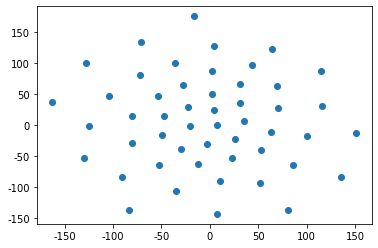

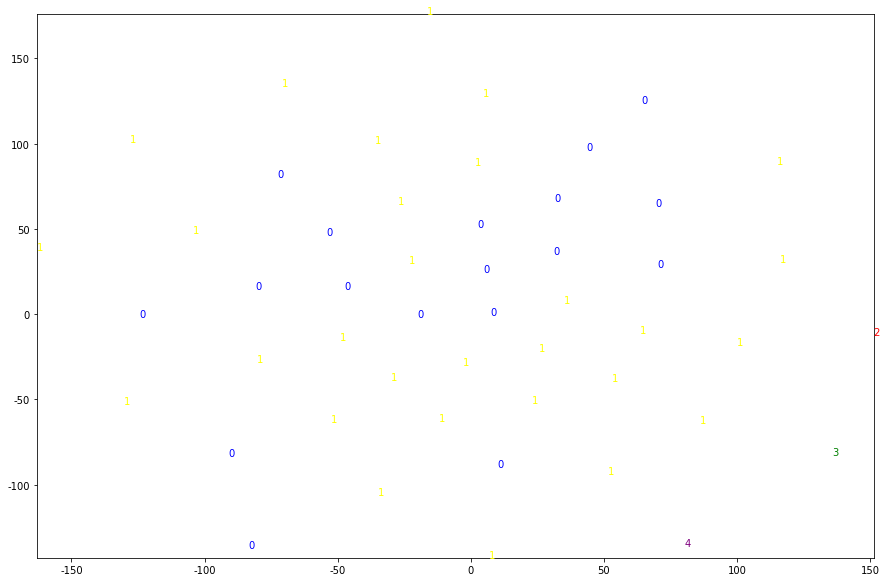

In [40]:
colors = {0:'blue', 1:'yellow', 2:'red', 3:'green', 4:'purple'}
x1 = tsne_review[:,0]
x2 = tsne_review[:,1]
plt.scatter(x1, x2)

plt.figure(figsize=(15,10))
plt.xlim(min(x1), max(x1))
plt.ylim(min(x2), max(x2))
for i in range(len(x1)):
#    plt.text(X1_lsi[i], X2_lsi[i], sample_label[i],
#            color = colors[sample_label[i]])
    plt.text(x1[i], x2[i], kmeans.labels_[i],
            color = colors[kmeans.labels_[i]])

#for word, pos in df.iterrows():
#    ax.annotate(word, pos, fontsize=30)
plt.show()

#아래 결과를 보면 각 topic들이 고르게 분포하고 있어, 클러스터링이 별로 의미 없음을 알 수 있음

#### 최적의 결과를 찾기 위한 방법
적절한 topic의 수는 perplexity 값을 이용해 찾음.<br>
낮을 수록 좋은 모형이나, 사람의 판단과 일치하지 않을 수 있음<br>
http://qpleple.com/perplexity-to-evaluate-topic-models/ <br>
그 외에 alpha, beta는 앞서 설명한 바와 같이 beta=0.1로 고정하고 alpha를 50/토픽수 근처에서 찾아나감<br>
반복횟수는 5,000번 정도면 수렴

In [41]:
lda.perplexity(review_cv)

580.4389729142897

In [42]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 25, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=2.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)
lda.perplexity(review_cv)

Topic #0: 영화, 스토리, 연기, 저승, 감동, 악역, 조폭, 상영, 윤계상, 지금
Topic #1: 영화, 가족, 감동, 노래, 디즈니, 점수, 주연, 자신, 조연, 픽사
Topic #2: 영화, 감동, 동안, 진짜, 더욱, 최고, 음악, 마음, 폭력, 장르
Topic #3: 인간, 엄마, 진짜, 하정우, 사람, 어머니, 모습, 영화, 하나, 순간
Topic #4: 광주, 영화, 국민, 전두환, 우리, 절대, 민주화, 당시, 해도, 외국
Topic #5: 영화, 신파, 중간, 연기, 명작, 코코, 정말, 기술, 언제, 몰입
Topic #6: 영화, 생각, 극장, 스토리, 재미, 가지, 감동, 걱정, 출연, 대박
Topic #7: 영화, 연출, 대한민국, 흥행, 반전, 얘기, 형사, 역사, 슬픔, 죽음
Topic #8: 영화, 차태현, 한국, 세계, 제대로, 신파극, 위해, 인정, 발전, 효과
Topic #9: 다음, 영화, 범죄, 편이, 추천, 마블, 도시, 꿀잼, 마동석, 번역
Topic #10: 영화, 감동, 만화, 부분, 대해, 자극, 볼거리, 정말, 생각, 스릴
Topic #11: 영화, 연기, 아쉬움, 마동석, 윤계상, 긴장감, 완성, 스크린, 평점, 기대
Topic #12: 원작, 영화, 스토리, 웹툰, 지옥, 아들, 오히려, 개연, 대사, 전혀
Topic #13: 영화, 어벤져스, 마블, 시리즈, 정말, 토르, 기대, 윤계상, 재미, 캐릭터
Topic #14: 영화, 눈물, 시민, 진실, 중반, 민주주의, 역사, 연기력, 실화, 등장
Topic #15: 영화, 관객, 정말, 시대, 모두, 감동, 희생, 남자, 나라, 배우
Topic #16: 영화, 영상, 이제, 집중, 감성, 감독, 배우, 정말, 눈물, 겨울왕국
Topic #17: 영화, 설정, 상황, 기분, 친구, 생각, 사실, 그때, 부모님, 조금
Topic #18: 영화, 이후, 이상, 보지, 관람, 평점, 역대, 감사, 알바, 진짜
Topic #19: 송강호, 영화, 배우, 택시,

561.3275384377573

In [43]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 10, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)
lda.perplexity(review_cv)

Topic #0: 감동, 보고, 스토리, 작품, 노스, 주인공, 모든, 어벤져스, 이제, 가장
Topic #1: 연기, 배우, 최고, 가족, 모두, 보기, 소재, 연기력, 조연, 이상
Topic #2: 영화, 음악, 부분, 인생, 최악, 여운, 영상, 뮤지컬, 보지, 무엇
Topic #3: 사람, 진짜, 하나, 차태현, 대박, 하정우, 소리, 인간, 지옥, 엄마
Topic #4: 광주, 역사, 다시, 가슴, 우리, 송강호, 한번, 택시, 지금, 사실
Topic #5: 정말, 눈물, 시간, 기대, 중간, 처음, 별로, 몰입, 실망, 관람
Topic #6: 생각, 재미, 스토리, 내용, 원작, 정도, 신파, 이해, 웹툰, 조금
Topic #7: 마지막, 장면, 감독, 사랑, 역시, 연출, 기억, 아이, 이야기, 대한
Topic #8: 그냥, 평점, 한국, 공포영화, 수준, 관객, 공포, 천만, 느낌, 한국영
Topic #9: 마동석, 윤계상, 마블, 액션, 완전, 추천, 다음, 결말, 때문, 아주



415.01169901486094